加载已训练模型: first_model.pth


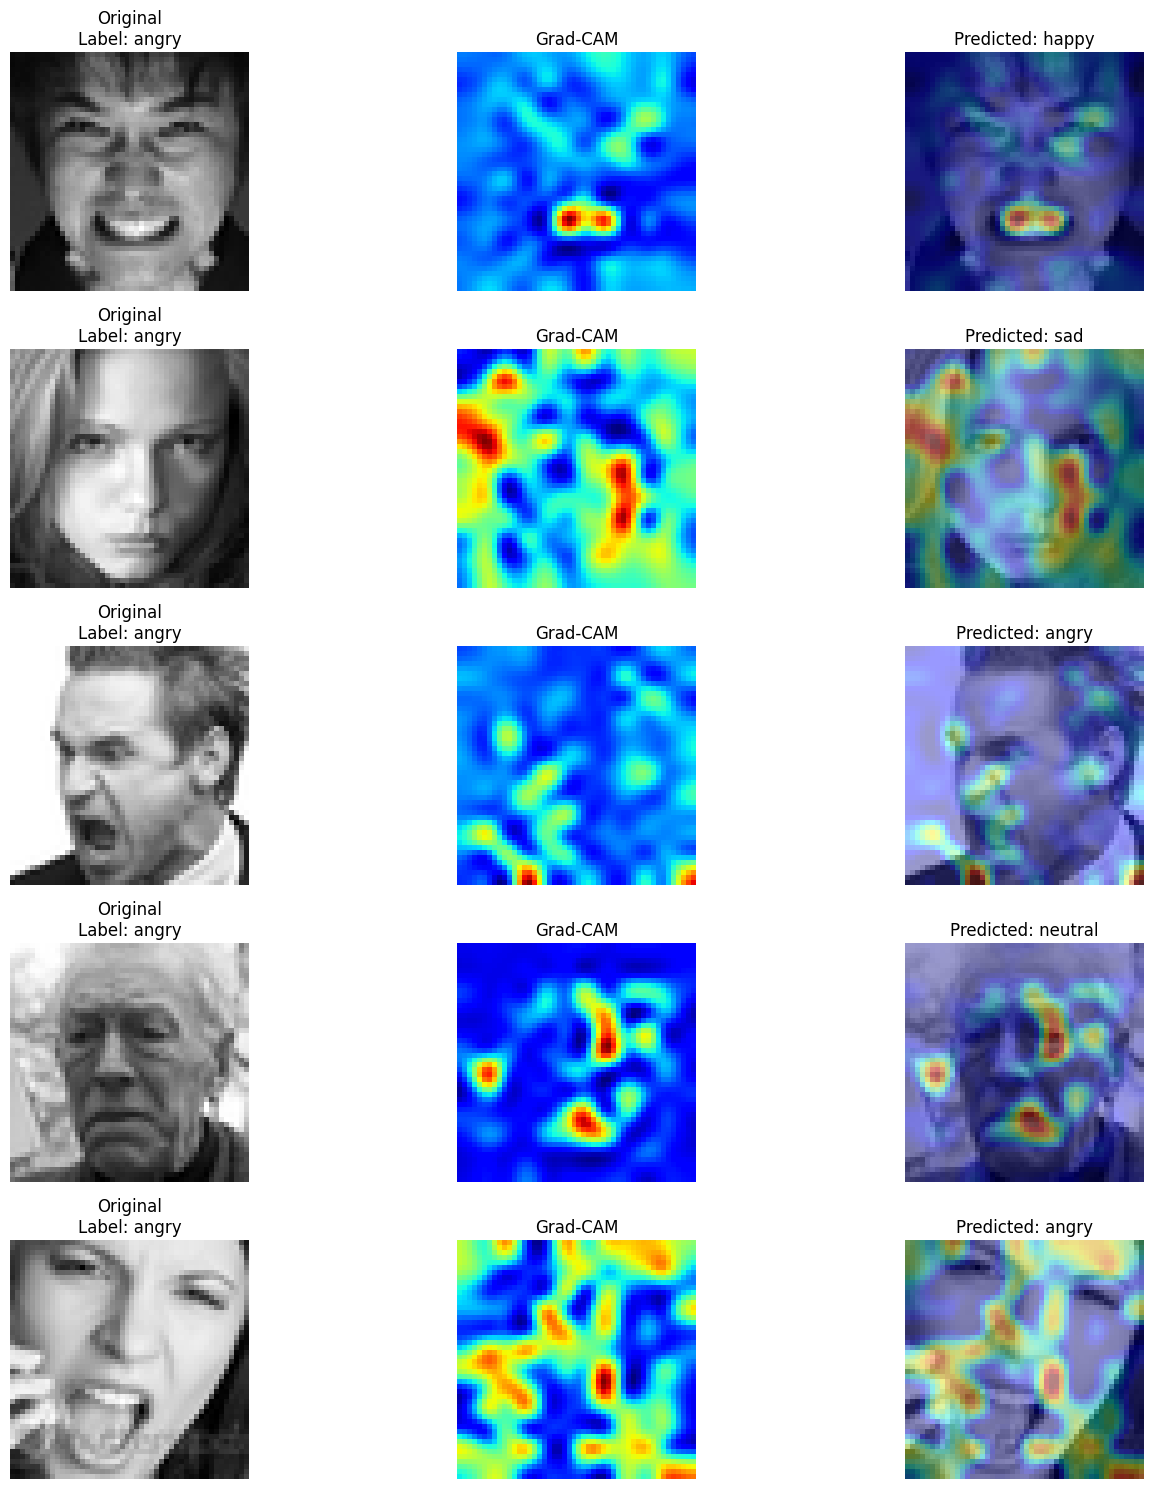

加载已训练模型: second_model.pth

Evaluating First Model...


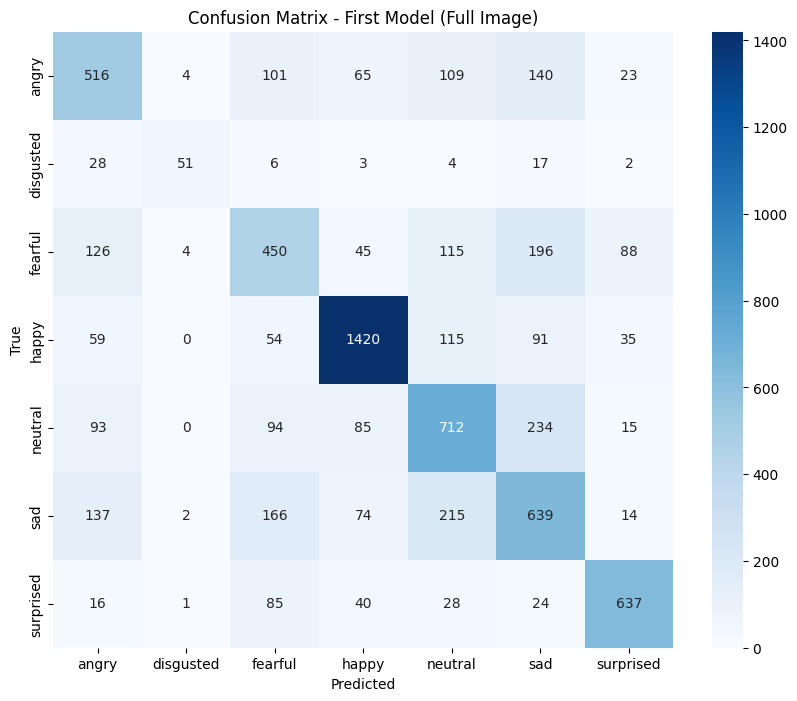


Classification Report - First Model (Full Image):

              precision    recall  f1-score   support

       angry       0.53      0.54      0.53       958
   disgusted       0.82      0.46      0.59       111
     fearful       0.47      0.44      0.45      1024
       happy       0.82      0.80      0.81      1774
     neutral       0.55      0.58      0.56      1233
         sad       0.48      0.51      0.49      1247
   surprised       0.78      0.77      0.77       831

    accuracy                           0.62      7178
   macro avg       0.64      0.58      0.60      7178
weighted avg       0.62      0.62      0.62      7178


Evaluating Second Model...


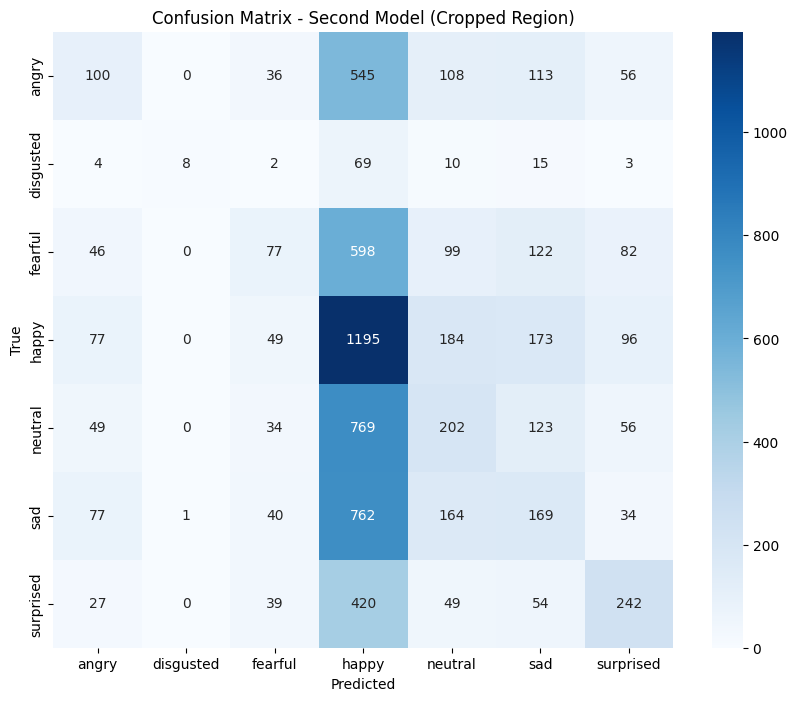


Classification Report - Second Model (Cropped Region):

              precision    recall  f1-score   support

       angry       0.26      0.10      0.15       958
   disgusted       0.89      0.07      0.13       111
     fearful       0.28      0.08      0.12      1024
       happy       0.27      0.67      0.39      1774
     neutral       0.25      0.16      0.20      1233
         sad       0.22      0.14      0.17      1247
   surprised       0.43      0.29      0.35       831

    accuracy                           0.28      7178
   macro avg       0.37      0.22      0.21      7178
weighted avg       0.29      0.28      0.24      7178



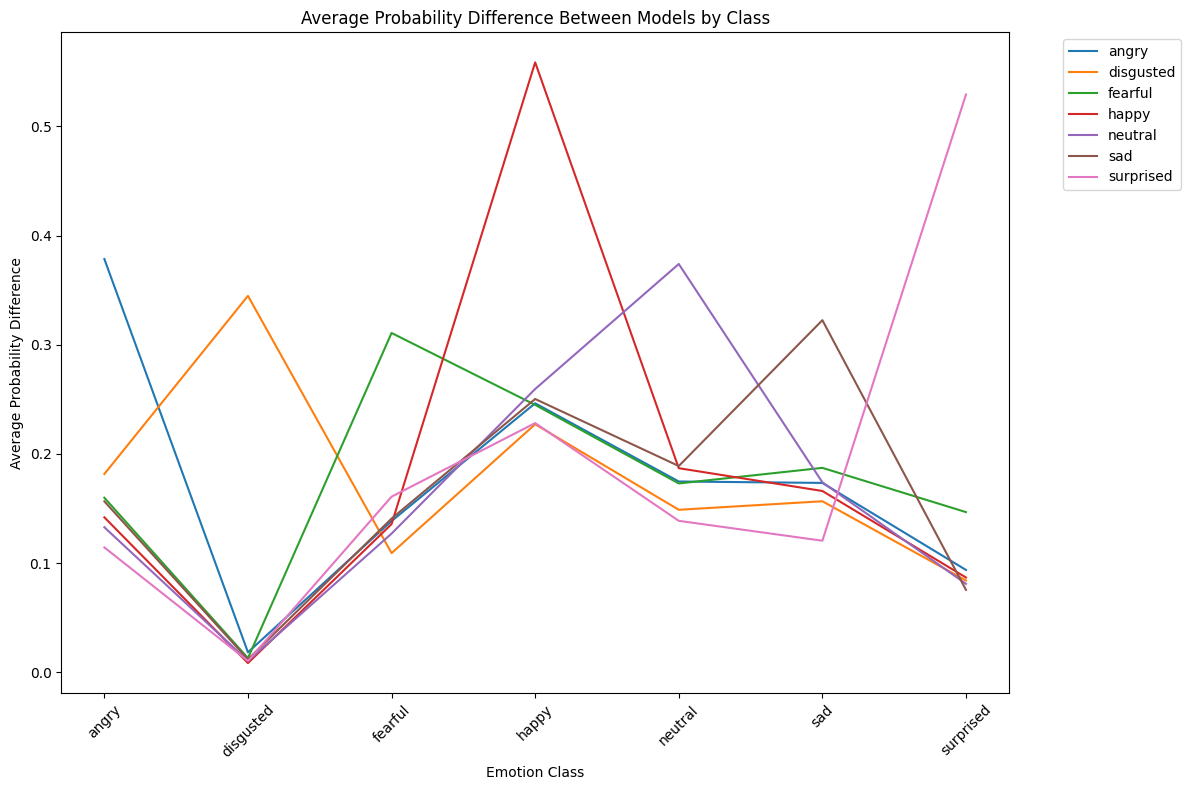

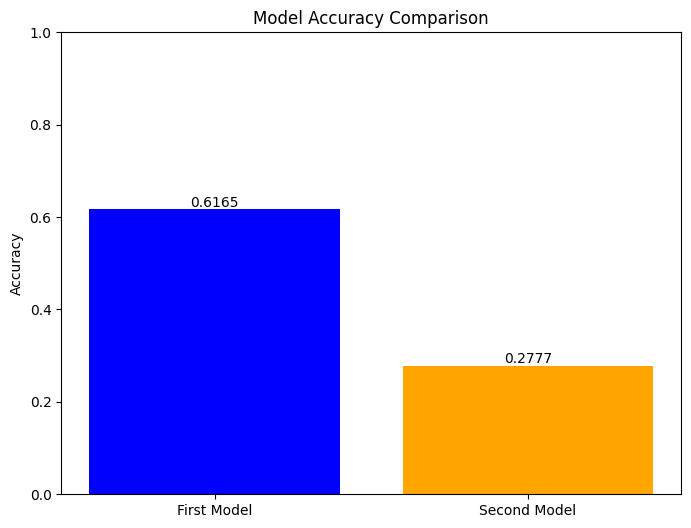

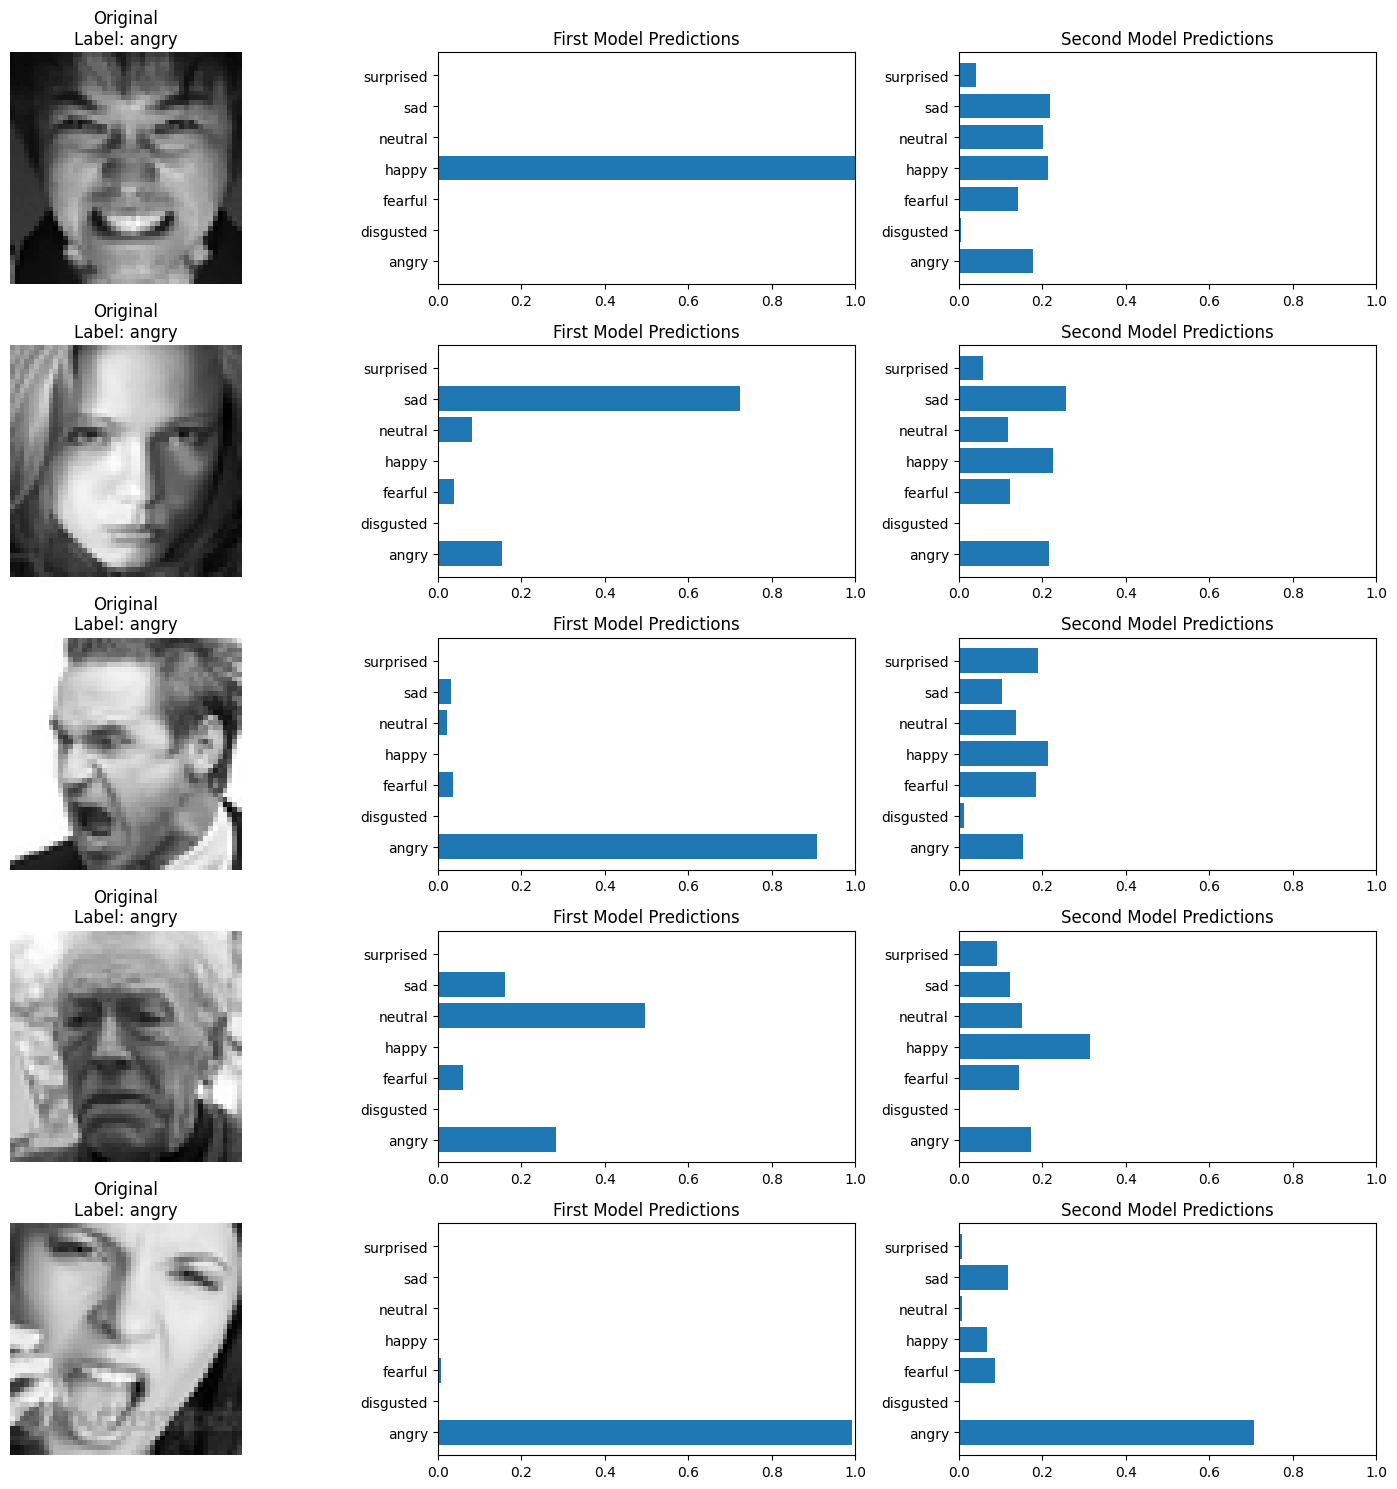

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# 设置随机种子保证可重复性
torch.manual_seed(42)
np.random.seed(42)

# 1. 数据导入和预处理
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()
        
    def _load_images(self):
        images = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith('.png'):
                    img_path = os.path.join(class_dir, img_name)
                    images.append((img_path, self.class_to_idx[class_name]))
        return images
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('L')  # 转换为灰度图
        if self.transform:
            image = self.transform(image)
        return image, label

# 数据转换
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 加载数据集
train_dataset = EmotionDataset('./data/train', transform=transform)
test_dataset = EmotionDataset('./data/test', transform=transform)

# 数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. 搭建第一个CNN模型
class FirstCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(FirstCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def get_activations(self, x):
        # 获取最后一个卷积层的激活
        activations = []
        for layer in self.features:
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                activations = x  # 只保留最后一个卷积层的激活
        return activations

# 3. 训练第一个模型或加载已训练模型
def train_model(model, train_loader, test_loader, num_epochs=20, model_path='first_model.pth'):
    if os.path.exists(model_path):
        print(f"加载已训练模型: {model_path}")
        model.load_state_dict(torch.load(model_path))
        return model
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    best_acc = 0.0
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # 测试集评估
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        
        # 保存最佳模型
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), model_path)
    
    # 绘制训练曲线
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(test_accs, label='Test Acc')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.show()
    
    return model

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss / len(data_loader), correct / total

# 训练第一个模型
first_model = FirstCNN()
first_model = train_model(first_model, train_loader, test_loader, num_epochs=10, model_path='first_model.pth')


# 4. 可视化第一个模型预测的重要区域 (使用Grad-CAM)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # 注册hook
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_full_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        device = next(self.model.parameters()).device

        # 确保输入需要梯度
        x = x.clone().requires_grad_(True)

        # 前向传播
        output = self.model(x)

        if class_idx is None:
            class_idx = torch.argmax(output).item()

        # 创建one-hot编码
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1

        # 反向传播
        self.model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)

        # 计算权重
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # 计算CAM
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / torch.max(cam)
        cam = cam.squeeze().cpu().numpy()

        return cam


# 获取目标层
target_layer = first_model.features[-2]  # 最后一个卷积层前的ReLU层

# 创建Grad-CAM实例
grad_cam = GradCAM(first_model, target_layer)


# 可视化一些样本的重要区域
def visualize_gradcam(loader, model, grad_cam, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    samples = []
    for inputs, labels in loader:
        samples.append((inputs[0], labels[0]))
        if len(samples) >= num_samples:
            break

    plt.figure(figsize=(15, 3 * num_samples))
    for i, (img, label) in enumerate(samples):
        # 临时启用梯度计算
        with torch.set_grad_enabled(True):
            img = img.unsqueeze(0).to(device).requires_grad_(True)
            output = model(img)
            pred_class = torch.argmax(output).item()
            cam = grad_cam(img, pred_class)
            cam = Image.fromarray(cam).resize((48, 48), Image.LANCZOS)
            cam = np.array(cam)

            # 原始图像 (灰度图处理)
            original_img = img.squeeze().detach().cpu().numpy()
            original_img = (original_img * 0.5 + 0.5) * 255  # 反归一化
            original_img = original_img.astype(np.uint8)

            # 叠加热力图 (灰度图特殊处理)
            heatmap = plt.cm.jet(cam)[..., :3] * 255  # 获取RGB热力图
            original_img_rgb = np.stack([original_img] * 3, axis=-1)  # 灰度转伪彩色
            superimposed_img = heatmap * 0.4 + original_img_rgb * 0.6
            superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

            # 显示
            plt.subplot(num_samples, 3, i * 3 + 1)
            plt.imshow(original_img, cmap="gray")
            plt.title(f"Original\nLabel: {test_dataset.classes[label]}")
            plt.axis("off")

            plt.subplot(num_samples, 3, i * 3 + 2)
            plt.imshow(cam, cmap="jet")
            plt.title("Grad-CAM")
            plt.axis("off")

            plt.subplot(num_samples, 3, i * 3 + 3)
            plt.imshow(superimposed_img)
            plt.title(f"Predicted: {test_dataset.classes[pred_class]}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


visualize_gradcam(test_loader, first_model, grad_cam, num_samples=5)


# 5. 根据重要区域分片并训练第二个模型
def crop_important_region(img, cam, crop_size=24):
    """裁剪图像中的重要区域
    Args:
        img: 输入图像(PIL Image或张量)
        cam: 热力图(NumPy数组)
        crop_size: 裁剪区域大小
    Returns:
        裁剪后的图像(与输入同类型)
    """
    # 找到热力图中响应最大的区域
    h, w = cam.shape
    y, x = np.unravel_index(np.argmax(cam), cam.shape)

    # 计算裁剪区域边界
    x_min = max(0, x - crop_size // 2)
    x_max = min(w, x + crop_size // 2)
    y_min = max(0, y - crop_size // 2)
    y_max = min(h, y + crop_size // 2)

    # 确保区域大小一致(边界情况)
    if x_max - x_min < crop_size:
        if x_min == 0:
            x_max = min(w, x_min + crop_size)
        else:
            x_min = max(0, x_max - crop_size)

    if y_max - y_min < crop_size:
        if y_min == 0:
            y_max = min(h, y_min + crop_size)
        else:
            y_min = max(0, y_max - crop_size)

    # 根据输入类型进行裁剪
    if isinstance(img, Image.Image):  # PIL Image
        cropped_img = img.crop((x_min, y_min, x_max, y_max))
    elif isinstance(img, torch.Tensor):  # PyTorch张量
        cropped_img = img[:, y_min:y_max, x_min:x_max]
    elif isinstance(img, np.ndarray):  # NumPy数组
        cropped_img = img[y_min:y_max, x_min:x_max]
    else:
        raise TypeError(f"Unsupported image type: {type(img)}")

    return cropped_img


class CroppedEmotionDataset(Dataset):
    def __init__(
        self,
        original_dataset,
        model,
        grad_cam,
        crop_size=24,
        device="cpu",
        transform=None,
    ):
        """
        Args:
            original_dataset: 原始数据集
            model: 用于生成CAM的模型
            grad_cam: GradCAM类实例
            crop_size: 裁剪区域大小(默认24)
            device: 计算设备(默认'cuda')
            transform: 应用于裁剪后图像的转换(可选)
        """
        self.original_dataset = original_dataset
        self.model = model
        self.grad_cam = grad_cam
        self.crop_size = crop_size
        self.device = device
        self.transform = transform  # 存储transform参数

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        img, label = self.original_dataset[idx]

        # 转换为PIL Image用于裁剪(如果还不是)
        if isinstance(img, torch.Tensor):
            img_pil = transforms.ToPILImage()(img.squeeze(0))
        elif isinstance(img, np.ndarray):
            img_pil = Image.fromarray(img)
        else:
            img_pil = img  # 假设已经是PIL Image

        # 生成热力图
        img_tensor = transforms.ToTensor()(img_pil).unsqueeze(0).to(self.device)
        img_tensor = img_tensor.requires_grad_(True)

        with torch.set_grad_enabled(True):
            output = self.model(img_tensor)
            pred_class = torch.argmax(output).item()
            cam = self.grad_cam(img_tensor, pred_class)  # 假设返回的是张量
            if isinstance(cam, torch.Tensor):  # 确保是张量
                cam = cam.detach().cpu().numpy()

        # 裁剪重要区域
        cropped_img = crop_important_region(img_pil, cam, self.crop_size)

        # 应用转换(如果存在)
        if self.transform is not None:
            cropped_img = self.transform(cropped_img)

        return cropped_img, label


# 创建裁剪后的数据集
cropped_train_dataset = CroppedEmotionDataset(train_dataset, first_model, grad_cam)
cropped_test_dataset = CroppedEmotionDataset(test_dataset, first_model, grad_cam)

# 调整转换器以适应裁剪后的尺寸
cropped_transform = transforms.Compose([
    transforms.Resize((24, 24)),  # 调整到统一大小
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# 应用转换
def apply_transform(dataset, transform):
    for i in range(len(dataset)):
        img, label = dataset[i]

        # 如果已经是张量，先转换为PIL图像
        if isinstance(img, torch.Tensor):
            img_pil = transforms.ToPILImage()(img)
        else:
            img_pil = img

        dataset[i] = (transform(img_pil), label)
    return dataset


cropped_train_dataset = CroppedEmotionDataset(
    train_dataset,
    first_model,
    grad_cam,
    crop_size=24,
    device="cpu",
    transform=cropped_transform,  # transform在这里传入
)
cropped_test_dataset = CroppedEmotionDataset(
    test_dataset,
    first_model,
    grad_cam,
    crop_size=24,
    device="cpu",
    transform=cropped_transform,  # transform在这里传入
)

# 创建裁剪后的数据加载器
cropped_train_loader = DataLoader(cropped_train_dataset, batch_size=batch_size, shuffle=True)
cropped_test_loader = DataLoader(cropped_test_dataset, batch_size=batch_size, shuffle=False)

# 6. 搭建第二个CNN模型 (针对裁剪后的图像)
class SecondCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SecondCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 训练第二个模型
second_model = SecondCNN()
second_model = train_model(second_model, cropped_train_loader, cropped_test_loader, 
                          num_epochs=10, model_path='second_model.pth')

# 7. 分析两个模型的性能
def evaluate_and_plot(model, loader, title):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)

    # 绘制热力图
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=test_dataset.classes,
        yticklabels=test_dataset.classes,
    )
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # 打印分类报告
    print(f"\nClassification Report - {title}:\n")
    print(
        classification_report(all_labels, all_preds, target_names=test_dataset.classes)
    )

    # 返回准确率
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    return accuracy

# 评估第一个模型
print("\nEvaluating First Model...")
first_model_accuracy = evaluate_and_plot(
    first_model, test_loader, "First Model (Full Image)"
)

# 评估第二个模型
print("\nEvaluating Second Model...")
second_model_accuracy = evaluate_and_plot(
    second_model, cropped_test_loader, "Second Model (Cropped Region)"
)


# 8. 对比两个模型的性能
def compare_models(first_model, second_model, test_loader, cropped_test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 获取两个模型在所有测试样本上的预测概率
    first_model_probs = []
    second_model_probs = []
    true_labels = []

    first_model.eval()
    second_model.eval()

    with torch.no_grad():
        # 第一个模型的预测
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = first_model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            first_model_probs.extend(probs.cpu().numpy())
            true_labels.extend(labels.numpy())

        # 第二个模型的预测
        for inputs, labels in cropped_test_loader:
            inputs = inputs.to(device)
            outputs = second_model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            second_model_probs.extend(probs.cpu().numpy())

    # 转换为numpy数组
    first_model_probs = np.array(first_model_probs)
    second_model_probs = np.array(second_model_probs)
    true_labels = np.array(true_labels)

    # 计算每个样本两个模型的预测差异
    prob_diffs = np.abs(first_model_probs - second_model_probs)
    avg_diff_per_class = [
        np.mean(prob_diffs[true_labels == i], axis=0)
        for i in range(len(test_dataset.classes))
    ]

    # 绘制每个类别的概率差异
    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(test_dataset.classes):
        plt.plot(avg_diff_per_class[i], label=class_name)

    plt.title("Average Probability Difference Between Models by Class")
    plt.xlabel("Emotion Class")
    plt.ylabel("Average Probability Difference")
    plt.xticks(range(len(test_dataset.classes)), test_dataset.classes, rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # 绘制两个模型的准确率对比
    plt.figure(figsize=(8, 6))
    models = ["First Model", "Second Model"]
    accuracies = [first_model_accuracy, second_model_accuracy]
    bars = plt.bar(models, accuracies, color=["blue", "orange"])

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.4f}",
            ha="center",
            va="bottom",
        )

    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.show()


# 对比两个模型
compare_models(first_model, second_model, test_loader, cropped_test_loader)


# 9. 可视化两个模型对同一批样本的预测
def visualize_predictions(
    first_model, second_model, loader, cropped_loader, num_samples=5
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 获取样本
    first_samples = []
    second_samples = []
    for (full_img, full_label), (cropped_img, _) in zip(loader, cropped_loader):
        first_samples.append((full_img[0], full_label[0]))
        second_samples.append(cropped_img[0])
        if len(first_samples) >= num_samples:
            break

    # 预测
    first_model.eval()
    second_model.eval()

    plt.figure(figsize=(15, 3 * num_samples))
    for i in range(num_samples):
        full_img, full_label = first_samples[i]
        cropped_img = second_samples[i]

        # 第一个模型的预测
        full_input = full_img.unsqueeze(0).to(device)
        with torch.no_grad():
            full_output = first_model(full_input)
            full_probs = (
                torch.nn.functional.softmax(full_output, dim=1).cpu().numpy()[0]
            )

        # 第二个模型的预测
        cropped_input = cropped_img.unsqueeze(0).to(device)
        with torch.no_grad():
            cropped_output = second_model(cropped_input)
            cropped_probs = (
                torch.nn.functional.softmax(cropped_output, dim=1).cpu().numpy()[0]
            )

        # 显示原始图像
        plt.subplot(num_samples, 3, i * 3 + 1)
        original_img = full_img.squeeze().numpy()
        original_img = (original_img * 0.5 + 0.5) * 255  # 反归一化
        plt.imshow(original_img, cmap="gray")
        plt.title(f"Original\nLabel: {test_dataset.classes[full_label]}")
        plt.axis("off")

        # 显示第一个模型的预测概率
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.barh(test_dataset.classes, full_probs)
        plt.title("First Model Predictions")
        plt.xlim(0, 1)

        # 显示第二个模型的预测概率
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.barh(test_dataset.classes, cropped_probs)
        plt.title("Second Model Predictions")
        plt.xlim(0, 1)

    plt.tight_layout()
    plt.show()


# 可视化预测对比
visualize_predictions(
    first_model, second_model, test_loader, cropped_test_loader, num_samples=5
)